# Жим штанги лёжа - предсказание рекорда. Описание проекта.

Сылка на Kaggle: https://www.kaggle.com/datasets/kukuroo3/powerlifting-benchpress-weight-predict

В данном датасете представлена информация о спортсменах - пауэрлифтерах: их данные и рекорды в трёх основных упражнениях (присед, становая тяга, жим лёжа). Рекорд в жиме лёжа в данном проекте является целевым признаком, для предсказания его на основе остальных признаков будет решаться задача регрессии. В качестве метрики будем использовать MAPE.

# Загрузка и обработка данных.

Загружаем необходимые нам библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

!pip install catboost
from catboost import CatBoostRegressor

!pip install phik
from phik import report
from phik.report import plot_correlation_matrix

Фиксируем переменную для random state.

In [2]:
RNDM_STATE = 42

Загружаем данные.

In [3]:
X_train = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Powerlifting/X_train.csv',
    sep=',')
y_train = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Powerlifting/y_train.csv',
    sep=',')
X_test = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Powerlifting/X_test.csv',
    sep=',')
y_test = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Powerlifting/y_test.csv',
    sep=',')

Все данные сразу разбиты на выборки, но нам это неудобно, позже разобьём сами.


Сначала исследуем таблицы, для этого напишем функцию, затем входящие признаки выборок с таргетом, а после-всё объединим в одну таблицу.


In [4]:
def df_info(df):
    print(df.info())
    print('')
    display(df.sample(10))
    print('')
    display(df.describe())
    print('')
    print(f'Количество явных дубликатов в датафрейме: {df.duplicated().sum()}.')
    print('')
    print(
        f'Количество неявных дубликатов в датафрейме: {df.duplicated(subset=["playerId"], keep=False).sum()}.'
    )
    print('')
    print('Процент пропусков по столбцам:')
    display(
        pd.DataFrame(round(df.isna().mean() * 100, 2)).style.background_gradient(
            'coolwarm'
        )
    )

In [5]:
df_info(X_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        18900 non-null  float64
 1   Name            18900 non-null  object 
 2   Sex             18900 non-null  object 
 3   Equipment       18900 non-null  object 
 4   Age             18725 non-null  float64
 5   BodyweightKg    18900 non-null  float64
 6   BestSquatKg     18900 non-null  object 
 7   BestDeadliftKg  18900 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.2+ MB
None



,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
6347,29260.0,Paul Burrows Jr,M,Wraps,21.0,93.21,202.5,215.0
18824,17159.0,Geoff Hopkins,M,Raw,26.5,104.15,200.0,290.0
11466,24012.0,Cardell Oliver,M,Wraps,36.0,98.60,272.5,305.0
13493,238.0,Josue Sanchez,M,Raw,26.0,73.20,150.0,205.0
2742,28797.0,Jakub Sedlacek,M,Raw,26.5,91.38,290.0,270.0
2729,23262.0,Louis-Philippe Tremblay,M,Raw,25.0,82.64,170.0,197.5
12235,17793.0,Fedor Vershinin,M,Wraps,21.0,105.80,240.0,280.0
13874,27398.0,Ryan Foubert,M,Raw,13.0,75.20,102.5,137.5
6651,19108.0,Steven Wang,M,Raw,23.0,72.85,142.5,132.5
8586,20899.0,Will Lau,M,Raw,38.0,67.20,100.0,165.0


,playerId,Age,BodyweightKg,BestDeadliftKg
count,18900.00000,18725.00000,18900.000000,18900.00000
mean,15039.49963,29.66470,85.425557,201.12277
std,8674.67268,11.55708,22.959720,62.17163
min,0.00000,7.00000,26.130000,18.10000
25%,7462.75000,21.50000,67.700000,149.85750
50%,15122.50000,26.50000,82.100000,204.12000
75%,22540.25000,35.00000,98.970000,247.50000
max,29998.00000,83.00000,201.000000,408.23000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
Name,0.000000
Sex,0.000000
Equipment,0.000000
Age,0.930000
BodyweightKg,0.000000
BestSquatKg,0.000000
BestDeadliftKg,0.000000


Пропуски в возрасте заполняем медианой.

In [6]:
X_train['Age'].fillna(X_train['Age'].median(), inplace=True)

In [7]:
df_info(y_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerId     18900 non-null  float64
 1   BestBenchKg  18900 non-null  float64
dtypes: float64(2)
memory usage: 295.4 KB
None



,playerId,BestBenchKg
14990,24000.0,87.5
8434,27138.0,72.5
16720,18207.0,165.0
13355,22260.0,122.5
8572,788.0,132.5
18825,27132.0,150.0
7774,25894.0,107.5
2130,29182.0,95.0
104,27984.0,75.0
6770,19443.0,112.5


,playerId,BestBenchKg
count,18900.00000,18900.000000
mean,15039.49963,116.963389
std,8674.67268,51.231651
min,0.00000,9.100000
25%,7462.75000,72.500000
50%,15122.50000,115.000000
75%,22540.25000,150.000000
max,29998.00000,425.000000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
BestBenchKg,0.000000


Объединяем.

In [8]:
train_df = pd.merge(X_train, y_train, on='playerId')
train_df

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,19391.0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.00,125.00
1,15978.0,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.00,157.50
2,27209.0,Levi Lehman,M,Raw,26.0,112.40,142.5,220.00,145.00
3,27496.0,Stacy Hayford,F,Raw,35.0,59.42,95.0,102.50,60.00
4,20293.0,Brittany Hirt,F,Raw,26.5,61.40,105.0,127.50,60.00
...,...,...,...,...,...,...,...,...,...
18895,29802.0,Rachael Podolak,F,Raw,20.0,65.70,92.5,135.00,55.00
18896,5390.0,Daniel Andersen,M,Raw,23.5,88.85,190.0,230.00,125.00
18897,860.0,Mark Brewer,M,Multi-ply,43.0,106.78,206.38,229.06,151.95
18898,15795.0,Michael Perkins,M,Raw,22.5,82.00,235.0,272.50,135.00


In [9]:
df_info(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11100 entries, 0 to 11099
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        11100 non-null  float64
 1   Name            11100 non-null  object 
 2   Sex             11100 non-null  object 
 3   Equipment       11100 non-null  object 
 4   Age             10855 non-null  float64
 5   BodyweightKg    11100 non-null  float64
 6   BestSquatKg     11100 non-null  float64
 7   BestDeadliftKg  11100 non-null  float64
dtypes: float64(5), object(3)
memory usage: 693.9+ KB
None



,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
9300,8497.0,DJ Moore,M,Wraps,23.0,116.50,230.00,255.00
2357,20956.0,Bradley Hutton,M,Raw,24.0,103.56,195.00,240.00
6303,3693.0,Dakota Smith,M,Raw,16.0,74.60,122.50,140.00
832,7964.0,Patience Miller,F,Raw,19.5,80.80,102.50,142.50
9959,8146.0,James Van Eerden,M,Wraps,26.0,75.00,149.69,181.44
1714,29294.0,Blake Reiman,M,Wraps,24.0,67.50,199.58,224.53
3927,23843.0,Olga Vorotnikova,F,Raw,39.5,61.99,142.50,180.00
1365,8023.0,Elena Cormino,F,Raw,41.0,66.50,120.00,127.50
5898,4472.0,Joshua Pinon',M,Raw,29.0,66.20,147.50,182.50
1014,8525.0,Abby Kasper,F,Single-ply,14.5,65.73,102.10,136.10


,playerId,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
count,11100.000000,10855.000000,11100.000000,11100.000000,11100.000000
mean,14931.392523,29.703086,85.245934,179.352391,201.099868
std,8636.003197,11.609336,22.749439,69.410025,62.709112
min,3.000000,8.500000,24.100000,20.000000,25.000000
25%,7551.750000,21.500000,68.522500,124.730000,147.500000
50%,14823.500000,26.500000,82.100000,175.000000,204.120000
75%,22404.250000,35.000000,98.700000,222.500000,247.500000
max,29999.000000,89.500000,242.400000,532.970000,420.500000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
Name,0.000000
Sex,0.000000
Equipment,0.000000
Age,2.210000
BodyweightKg,0.000000
BestSquatKg,0.000000
BestDeadliftKg,0.000000


Снова заполняем пропуски в данных о возрасте медианным значением.

In [10]:
X_test['Age'].fillna(X_test['Age'].median(), inplace=True)

In [11]:
df_info(y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11100 entries, 0 to 11099
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        11100 non-null  float64
 1   BestBenchKg     11100 non-null  float64
 2   Age             0 non-null      float64
 3   BodyweightKg    0 non-null      float64
 4   BestDeadliftKg  0 non-null      float64
dtypes: float64(5)
memory usage: 433.7 KB
None



,playerId,BestBenchKg,Age,BodyweightKg,BestDeadliftKg
1960,29516.0,45.0,NaN,NaN,NaN
5053,1807.0,135.0,NaN,NaN,NaN
9476,26332.0,135.0,NaN,NaN,NaN
2537,16933.0,100.0,NaN,NaN,NaN
4901,24050.0,162.5,NaN,NaN,NaN
7094,16882.0,95.0,NaN,NaN,NaN
7368,8815.0,120.0,NaN,NaN,NaN
6330,9676.0,127.5,NaN,NaN,NaN
574,6400.0,155.0,NaN,NaN,NaN
1031,17546.0,157.5,NaN,NaN,NaN


,playerId,BestBenchKg,Age,BodyweightKg,BestDeadliftKg
count,11100.000000,11100.000000,0.0,0.0,0.0
mean,14931.392523,115.731901,NaN,NaN,NaN
std,8636.003197,54.209846,NaN,NaN,NaN
min,3.000000,-280.000000,NaN,NaN,NaN
25%,7551.750000,70.000000,NaN,NaN,NaN
50%,14823.500000,115.000000,NaN,NaN,NaN
75%,22404.250000,150.000000,NaN,NaN,NaN
max,29999.000000,377.500000,NaN,NaN,NaN



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
BestBenchKg,0.000000
Age,100.000000
BodyweightKg,100.000000
BestDeadliftKg,100.000000


Выкидываем пустые столбцы.

In [12]:
y_test = y_test.drop(['Age', 'BodyweightKg', 'BestDeadliftKg'], axis=1)

Отрицательные значения заменим на значения по модулю.

In [13]:
y_test['BestBenchKg'] = y_test['BestBenchKg'].abs()

Снова объединяем.

In [14]:
test_df = pd.merge(X_test, y_test, on='playerId')
test_df

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,2308.0,Peter Neeves,M,Wraps,30.0,89.81,179.17,192.78,97.52
1,22404.0,Josh Padilla,M,Raw,27.0,74.95,125.00,165.00,75.00
2,23397.0,Luke Dreier,M,Wraps,30.0,122.61,290.00,317.50,190.00
3,25058.0,Jacob New,M,Raw,20.0,88.00,187.50,240.00,117.50
4,2664.0,Jesse Burdick,M,Wraps,30.0,122.00,235.01,275.01,145.01
...,...,...,...,...,...,...,...,...,...
11095,3104.0,Dimitrios Rallis,M,Wraps,28.0,98.20,270.00,315.00,160.00
11096,10239.0,Amber Skewes,F,Raw,36.0,58.80,92.50,137.50,57.50
11097,29044.0,Brandon Mose,M,Raw,22.5,82.62,250.00,311.00,175.00
11098,29947.0,Missy Lavoie,F,Wraps,28.0,74.30,105.00,152.50,70.00


Объединяем всё в единую таблицу.

In [15]:
df = pd.concat([train_df, test_df], ignore_index=True)

Смотрим данные о ней.

In [16]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        30000 non-null  float64
 1   Name            30000 non-null  object 
 2   Sex             30000 non-null  object 
 3   Equipment       30000 non-null  object 
 4   Age             30000 non-null  float64
 5   BodyweightKg    30000 non-null  float64
 6   BestSquatKg     30000 non-null  object 
 7   BestDeadliftKg  30000 non-null  float64
 8   BestBenchKg     30000 non-null  float64
dtypes: float64(5), object(4)
memory usage: 2.1+ MB
None



,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
29813,13021.0,Kim-Raino Roelvaag,M,Single-ply,26.5,73.23,282.5,262.5,222.5
513,25313.0,Walter Gómez,M,Raw,26.5,58.84,180.0,215.0,127.5
8062,26165.0,Artyom Zharkov,M,Wraps,20.0,98.10,260.0,300.0,150.0
2715,29647.0,Jennifer Freytag,F,Raw,36.5,105.50,135.0,150.0,62.5
8935,21355.0,Linda Hooper,F,Raw,29.0,43.80,57.5,92.5,30.0
27290,7686.0,Shae Jones,M,Raw,34.0,105.14,272.5,272.5,210.0
2798,2493.0,Jessie Barlaan,M,Raw,20.0,56.97,152.5,165.0,92.5
12220,10553.0,Kris Wyskochil,M,Raw,37.0,99.43,120.0,160.0,80.0
27873,9480.0,Gerard Recinto,M,Raw,20.5,85.40,185.0,220.0,100.0
25638,16495.0,Aleksandra Artemyeva,F,Raw,21.0,57.50,95.0,110.0,47.5


,playerId,Age,BodyweightKg,BestDeadliftKg,BestBenchKg
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,14999.500000,29.634283,85.359097,201.114296,116.957666
std,8660.398374,11.500847,22.881926,62.369995,51.342817
min,0.000000,7.000000,24.100000,18.100000,9.100000
25%,7499.750000,21.500000,68.050000,147.500000,72.500000
50%,14999.500000,26.500000,82.100000,204.120000,115.000000
75%,22499.250000,34.500000,98.880000,247.500000,150.000000
max,29999.000000,89.500000,242.400000,420.500000,425.000000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
Name,0.000000
Sex,0.000000
Equipment,0.000000
Age,0.000000
BodyweightKg,0.000000
BestSquatKg,0.000000
BestDeadliftKg,0.000000
BestBenchKg,0.000000


Итого в собранном датасете имеем следующие признаки:
- playerId - идентификационный номер спортсмена;
- Name - имя спортсмена;
- Sex - пол спортсмена;
- Equipment - тип используемой экпипировки;
- Age - возраст спортсмена;
- BodyweightKg - масса тела спортсмена;
- BestSquatKg - рекорд в приседе со штангой, кг;
- BestDeadliftKg - рекорд в становой тяге, кг;
- BestBenchKg - рекорд в жиме штанги лёжа, кг (целевой признак).

Меняем тип данных у столбца с рекордами спортсменов в приседе на float.

In [17]:
df['BestSquatKg'] = pd.to_numeric(df['BestSquatKg'], errors='coerce')
df.dropna(subset=['BestSquatKg'], inplace=True)
df['BestSquatKg'] = df['BestSquatKg'].astype(float)
df['BestSquatKg']  = df['BestSquatKg'].abs()

Также сразу даляем бессмысленные для нашей задачи столбцы с именем спортсмена и идентификационным номером.

In [18]:
df = df.drop(['Name', 'playerId'], axis=1)

## Выводы по разделу.
- Загружены все необходимые для работы библиотеки и данные.
- Данные уже разделены на выборки, но нам удобнее объединить их вединый датасет, а после уже разбить самостоятельно.
- Пропуски в возрасте спортсменов заполнены медианным значением.
- Неверный тип данных столбца BestSquatKg заменён.
- Удалены бесполезные для дальнейшего машинного обучения данные об именах спортсменов и их идентификационных номерах в таблице.

# Построение графиков.

Посмотрим распределение данны численных переменных.

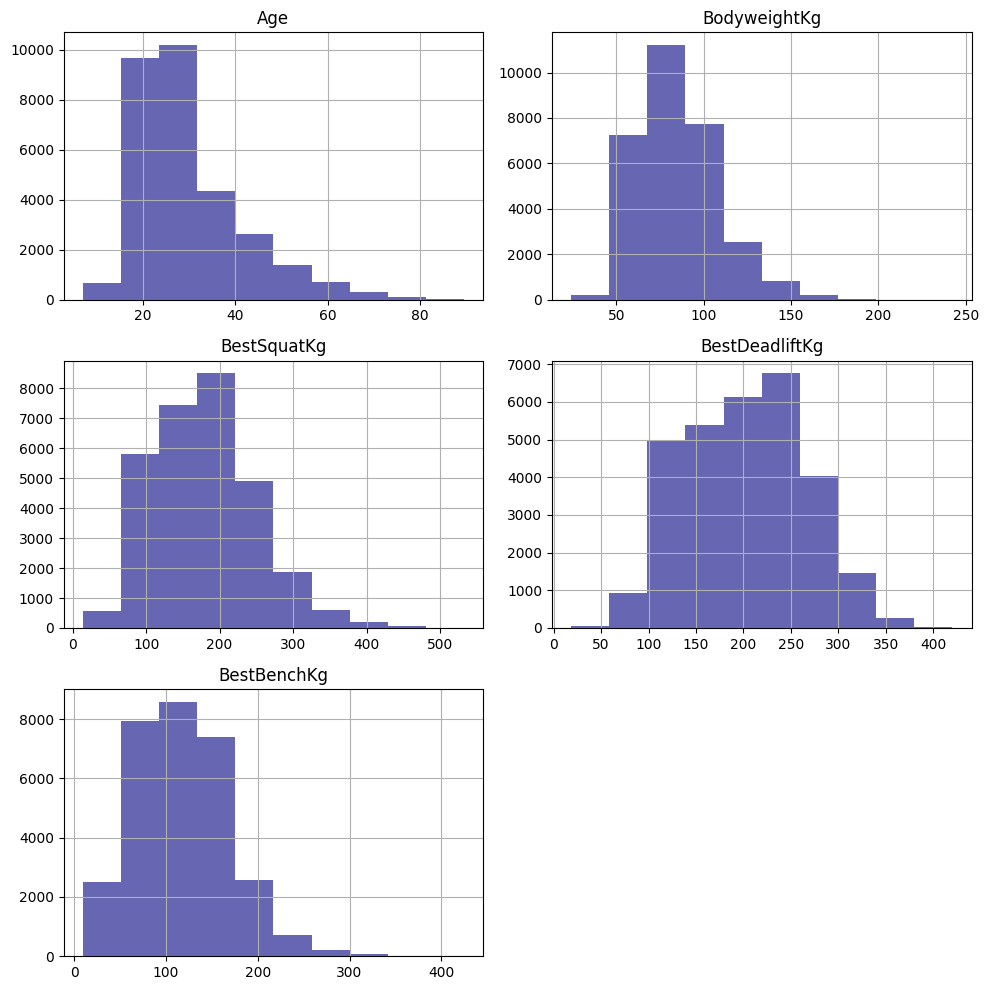

In [19]:
df.hist(figsize=(10, 10), color='navy', alpha = 0.6)
plt.tight_layout()
plt.show()

Смотрим в каких процентах представлены мужчины и женщины в наших данных.

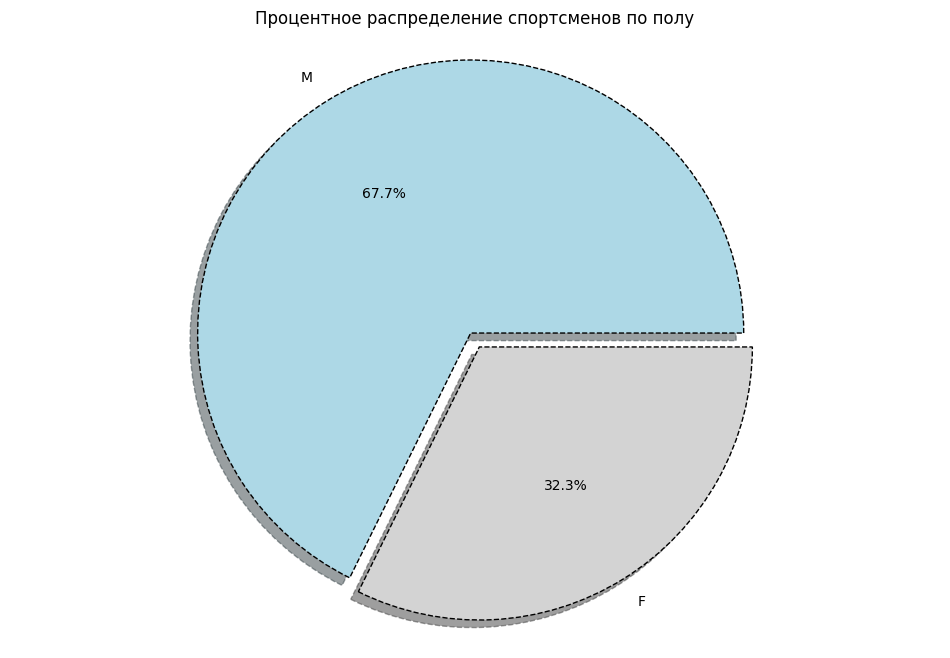

In [20]:
counts = df['Sex'].value_counts()

explode = [0.05, 0.01] + [0] * (len(counts) - 3)
plt.figure(figsize=(12, 8))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode,
    colors=['lightblue', 'lightgrey'] + ['C0'] * (len(counts) - 3),
    wedgeprops={'lw': 1, 'ls': '--', 'edgecolor': 'k'},
)
plt.axis('equal')
plt.title('Процентное распределение спортсменов по полу')
plt.show()

Смотрим медианные значения рекорда в жиме штанги лёжа для мужчин и женщин.

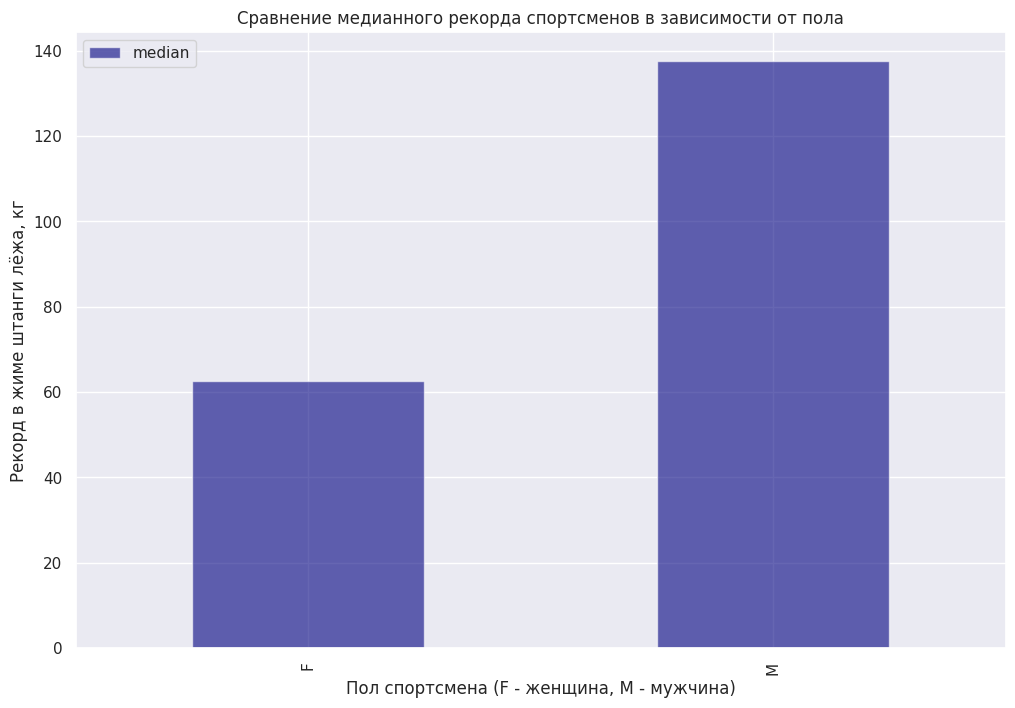

In [21]:
sex_best_bench_median = df.groupby('Sex')['BestBenchKg'].agg(['median']).sort_values(by='median')

sns.set(rc={'figure.figsize':(12, 8)})
sex_best_bench_median.plot(kind='bar', color='navy', alpha=0.6)

plt.xlabel('Пол спортсмена (F - женщина, M - мужчина)')
plt.ylabel('Рекорд в жиме штанги лёжа, кг')
plt.title('Сравнение медианного рекорда спортсменов в зависимости от пола')

plt.show()

Смотрим, чему равны медианные значения рекорда в жиме лёжа в зависимости от применяемой экипировки.

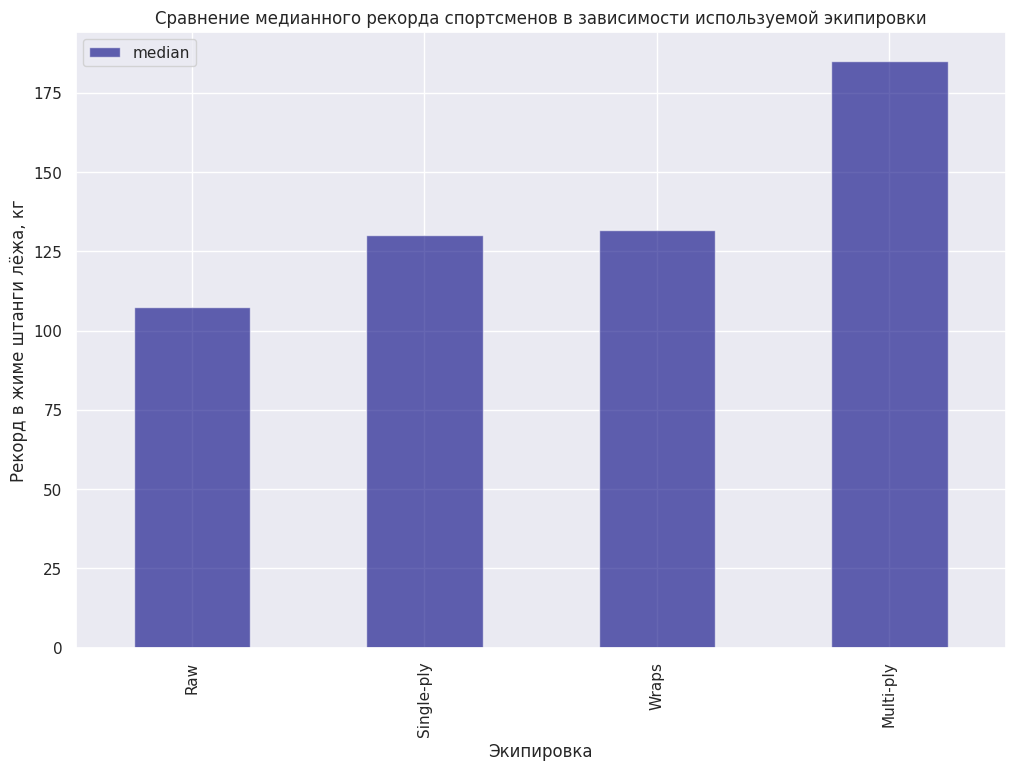

In [22]:
equipment_best_bench_median = (
    df.groupby('Equipment')['BestBenchKg'].agg(['median']).sort_values(by='median')
)

sns.set(rc={'figure.figsize': (12, 8)})
equipment_best_bench_median.plot(kind='bar', color='navy', alpha=0.6)
plt.xlabel('Экипировка')
plt.ylabel('Рекорд в жиме штанги лёжа, кг')
plt.title(
    'Сравнение медианного рекорда спортсменов в зависимости используемой экипировки'
)

plt.show()

Смотрим, как возраст спортсмена и его собственная масса влияют на рекорд в жиме лёжа.

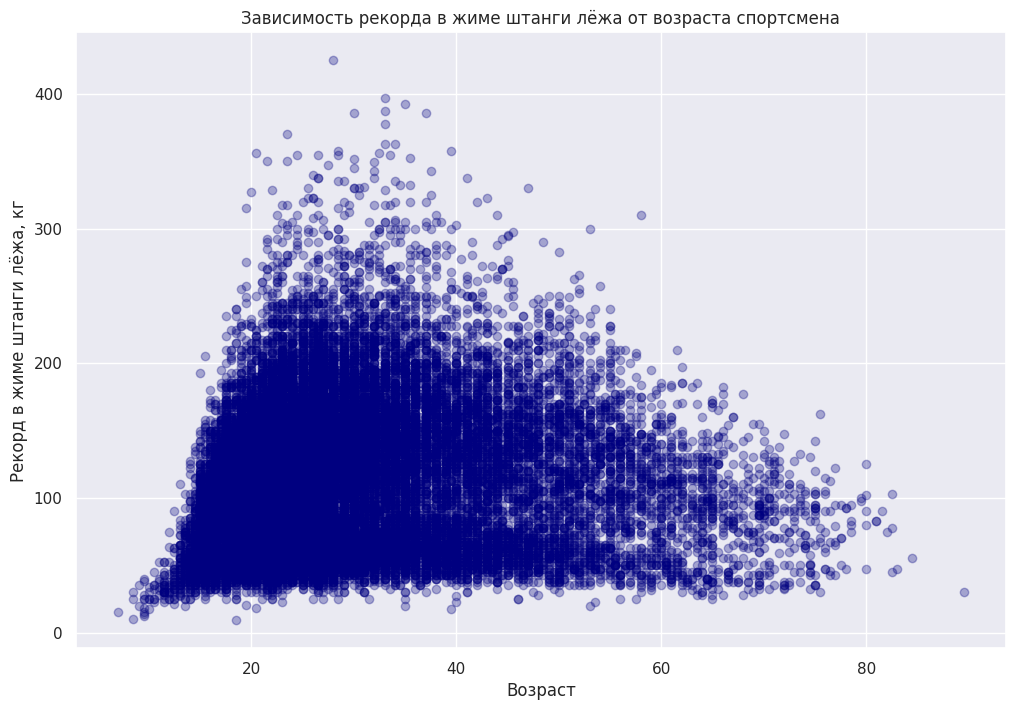

In [23]:
sns.set(rc={'figure.figsize':(12, 8)})
plt.scatter(df['Age'], df['BestBenchKg'], color='navy', alpha = 0.3)

plt.xlabel('Возраст')
plt.ylabel('Рекорд в жиме штанги лёжа, кг')
plt.title('Зависимость рекорда в жиме штанги лёжа от возраста спортсмена')

plt.show()

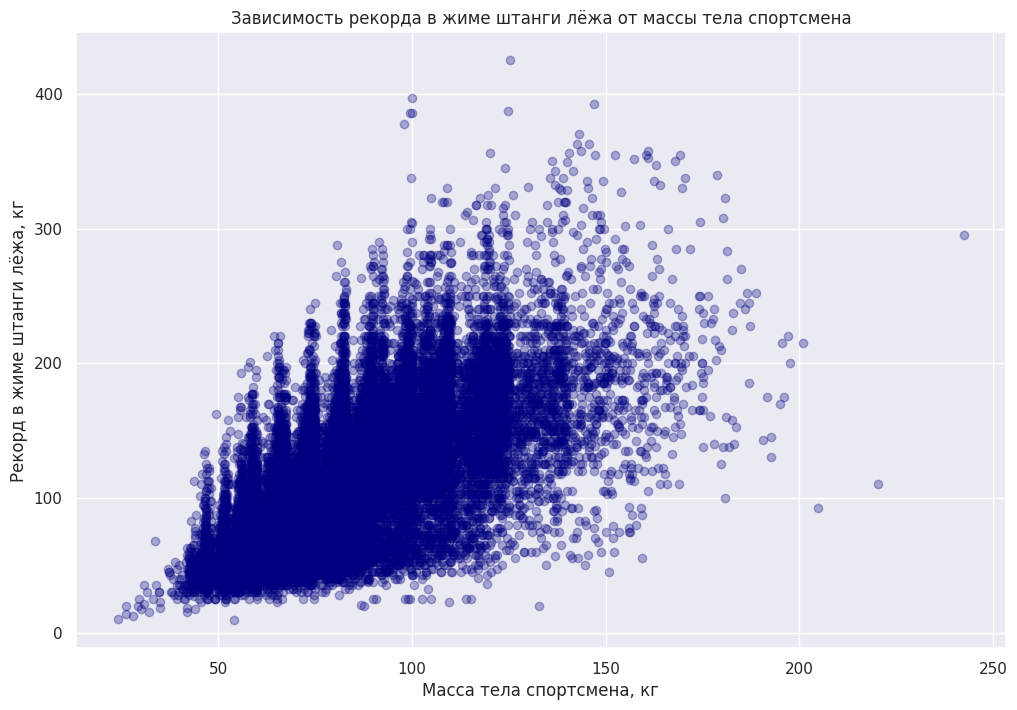

In [24]:
sns.set(rc={'figure.figsize':(12, 8)})
plt.scatter(df['BodyweightKg'], df['BestBenchKg'], color='navy', alpha = 0.3)

plt.xlabel('Масса тела спортсмена, кг')
plt.ylabel('Рекорд в жиме штанги лёжа, кг')
plt.title('Зависимость рекорда в жиме штанги лёжа от массы тела спортсмена')

plt.show()

И, наконец, смотрим, как рекорды в приседе со штангой и становой тяге влияют на лучший показатель в жиме лёжа.

In [25]:
fig = go.Figure(data=[go.Scatter3d(
    x=df['BestSquatKg'],
    y=df['BestDeadliftKg'],
    z=df['BestBenchKg'],
    mode='markers',
    marker=dict(
        color='navy',
        opacity=0.1
    )
)])

fig.update_layout(scene=dict(
    xaxis_title='Рекорд в приседе со штангой, кг',
    yaxis_title='Рекорд в становой тяге, кг',
    zaxis_title='Рекорд в жиме штанги лёжа, кг'
))

fig.show()

## Выводы по разделу.
- Больше всего в рассматриваемых данных представлено спортсменов от 20 до 30 лет и весовой категории до 100 кг.
- Мужчин в таблице в 2 раза больше, чем женщин.
- Медианное значение по таблице рекорда в жиме лёжа у женщин 62.5 кг, у мужчин 137.5 кг.
- По медианному значению (185 кг) наилучший показатель в жиме штанги лёжа получается при экипировке класс multiply.
- Также, исходя из графиков, можно предположить, что эти рекорды ставят в основном люди от 20 до 40 лет с собственной массой от 100 до 150 кг. Кроме того наилучших результатов в жиме лёжа предположительно в основном добавиются спортсмены с наилучшими показателями в приседе и становой тяги.

# Корреляции.

Смотрим корреляции признаков с помощью библиотеки phik.

In [26]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['Age', 'BodyweightKg', 'BestSquatKg', 'BestDeadliftKg', 'BestBenchKg']


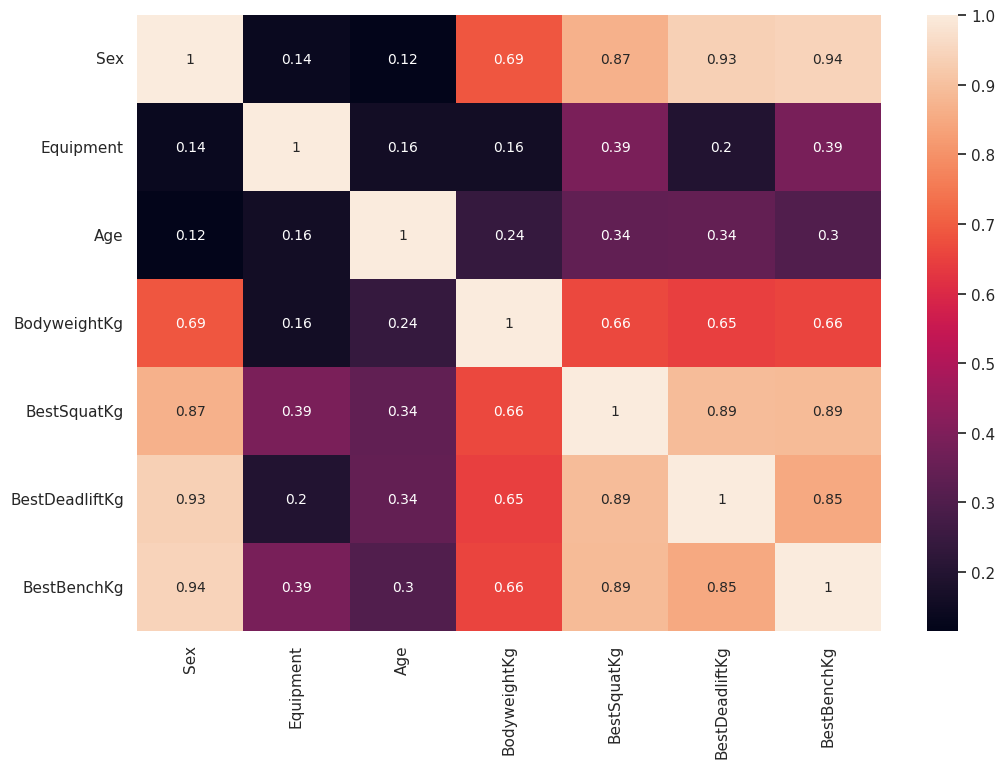

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(phik_overview, annot=True, annot_kws={'fontsize': 10})
plt.show()

Вызываем список корреляций с целевым признаком.

In [28]:
phik_overview['BestBenchKg'].sort_values(ascending = False)

BestBenchKg       1.000000
Sex               0.942693
BestSquatKg       0.889126
BestDeadliftKg    0.848117
BodyweightKg      0.655700
Equipment         0.386041
Age               0.302928
Name: BestBenchKg, dtype: float64

## Выводы по разделу.
- Исходя из значений коэффициента, все оставшиеся фичи ощутимо влияют на таргет.
- Видим сильную мультиколлинеарность признаков, обозначающих пол спортсмена, его рекорд в приседе со штангой и становой тягt. Далее для линейной модели оставим только первый из трёх этих признаков, остальные удалим. С моделью градиентного бустинга будем использовать полный датафрейм, т. к. она не чувствительна к мультиколлинеарности.

# Обучение моделей.

Переводим запись пола спортсменов в бинарный вид.

In [29]:
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})

Как было сказано выше, делаем копию полной таблицы для бустинга, для линейной модели удаляем из данных два признака.

In [30]:
df_full = df.copy()

df = df.drop(['BestSquatKg', 'BestDeadliftKg'], axis=1)

Создаём список с категориальными и числовыми признаками.

In [31]:
cat_features_names = ['Equipment']
num_features_names = ['Sex', 'BodyweightKg', 'Age']

Разбиваем данные для линейной модели сначала на тренировочную и валидационную + тестовую выборки.

In [32]:
df_train, df_valid_test = train_test_split(df, test_size = 0.4, random_state = RNDM_STATE)

In [33]:
features_train = df_train.drop(['BestBenchKg'], axis = 1)
target_train = df_train['BestBenchKg']
features_valid_test = df_valid_test.drop(['BestBenchKg'], axis = 1)
target_valid_test = df_valid_test['BestBenchKg']

Теперь разделяем валидационную и тестовую.

In [34]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size = 0.5, random_state = RNDM_STATE)

Кодируем категориальный признак, отвечающий за используемую спортсменами экипировку, с помощью OHE.

In [35]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

features_train_encoding = features_train.copy()
features_test_encoding = features_test.copy()
features_valid_encoding = features_valid.copy()

encoder_ohe.fit(features_train_encoding[cat_features_names])
new_columns = encoder_ohe.get_feature_names_out(cat_features_names)
train_ohe = pd.DataFrame(
    encoder_ohe.transform(features_train_encoding[cat_features_names]).toarray(),
    columns=new_columns,
    index=features_train.index,
)
features_train_ohe = train_ohe.join(features_train_encoding[num_features_names])

valid_ohe = pd.DataFrame(
    encoder_ohe.transform(features_valid_encoding[cat_features_names]).toarray(),
    columns=new_columns,
    index=features_valid.index,
)
features_valid_ohe = valid_ohe.join(features_valid_encoding[num_features_names])


test_ohe = pd.DataFrame(
    encoder_ohe.transform(features_test_encoding[cat_features_names]).toarray(),
    columns=new_columns,
    index=features_test_encoding.index,
)
features_test_ohe = test_ohe.join(features_test_encoding[num_features_names])

Выделяем небинарные числовые признаки и стандартизируем их.

In [36]:
not_bin_num_features_names = ['BodyweightKg', 'Age' ]

In [37]:
scaler = StandardScaler()

features_train_ohe_scaled = features_train_ohe.copy()
features_valid_ohe_scaled = features_valid_ohe.copy()
features_test_ohe_scaled = features_test_ohe.copy()

scaler.fit(features_train_ohe[not_bin_num_features_names])

features_train_ohe_scaled[not_bin_num_features_names] = scaler.transform(
    features_train_ohe_scaled[not_bin_num_features_names]
)
features_valid_ohe_scaled[not_bin_num_features_names] = scaler.transform(
    features_valid_ohe_scaled[not_bin_num_features_names]
)
features_test_ohe_scaled[not_bin_num_features_names] = scaler.transform(
    features_test_ohe_scaled[not_bin_num_features_names]
)

Для полной версии данных просто разбиваем данные на выборки.

In [38]:
df_train_full, df_valid_test_full = train_test_split(
    df_full, test_size=0.4, random_state=RNDM_STATE
)

features_train_full = df_train_full.drop(["BestBenchKg"], axis=1)
target_train_full = df_train_full["BestBenchKg"]
features_valid_test_full = df_valid_test_full.drop(["BestBenchKg"], axis=1)
target_valid_test_full = df_valid_test_full["BestBenchKg"]

(
    features_valid_full,
    features_test_full,
    target_valid_full,
    target_test_full,
) = train_test_split(
    features_valid_test_full,
    target_valid_test_full,
    test_size=0.5,
    random_state=RNDM_STATE,
)

Чтобы понять, от чего отталкиваться, посмотрим какую величину метрики MAPE выдаст у нас dummy-модель, просто предсказывающая для целевого признака медианное значение.

In [39]:
dummy = DummyRegressor(strategy='median')

dummy.fit(features_train_ohe_scaled, target_train)
predictions_dummy = dummy.predict(features_valid_ohe_scaled)
mape_dummy = np.mean(np.abs((target_valid - predictions_dummy) / target_valid)) * 100

print(f'Значение MAPE для dummy-модели на валидационной выборке: {mape_dummy}')

Значение MAPE для dummy-модели на валидационной выборке: 46.88997599407106


Теперь посмотрим, какую величину ошибки выдаст в аналогичной ситуации линейная регрессия.

In [40]:
lr = LinearRegression()

lr.fit(features_train_ohe_scaled, target_train)
predictions_lr = lr.predict(features_valid_ohe_scaled)
mape_lr = np.mean(np.abs((target_valid - predictions_lr) / target_valid)) * 100

print(
    f"Значение MAPE для модели линейной регрессии на валидационной выборке: {mape_lr}"
)

Значение MAPE для модели линейной регрессии на валидационной выборке: 22.106884785061744


Уже значительно лучше, но теперь протестируем модель градиентного бустинга в лице CatBoost.

In [41]:
model_cb = CatBoostRegressor(
    learning_rate=0.01,
    eval_metric="MAPE",
    cat_features=cat_features_names,
    random_seed=RNDM_STATE,
    depth=9,
    verbose=100,
    task_type="GPU",
)
model_cb.fit(
    features_train_full,
    target_train_full,
    eval_set=(features_valid_full, target_valid_full),
)

0:	learn: 0.4774832	test: 0.4720628	best: 0.4720628 (0)	total: 155ms	remaining: 2m 35s
100:	learn: 0.2249002	test: 0.2239018	best: 0.2239018 (100)	total: 16s	remaining: 2m 22s
200:	learn: 0.1455147	test: 0.1474328	best: 0.1474328 (200)	total: 29.7s	remaining: 1m 57s
300:	learn: 0.1237483	test: 0.1272543	best: 0.1272543 (300)	total: 34.8s	remaining: 1m 20s
400:	learn: 0.1173041	test: 0.1216737	best: 0.1216737 (400)	total: 40.8s	remaining: 1m
500:	learn: 0.1150582	test: 0.1199165	best: 0.1199165 (500)	total: 49s	remaining: 48.8s
600:	learn: 0.1140763	test: 0.1192197	best: 0.1192197 (600)	total: 54s	remaining: 35.8s
700:	learn: 0.1134549	test: 0.1188654	best: 0.1188654 (700)	total: 57.2s	remaining: 24.4s
800:	learn: 0.1130634	test: 0.1186373	best: 0.1186373 (800)	total: 1m	remaining: 14.9s
900:	learn: 0.1127545	test: 0.1185144	best: 0.1185144 (900)	total: 1m 5s	remaining: 7.25s
999:	learn: 0.1124793	test: 0.1184069	best: 0.1184069 (999)	total: 1m 8s	remaining: 0us
bestTest = 0.1184069411


Отлично, с помощью этой модели мы смогли снизить ошибку до 11.84%. Запустим эту же модель теперь с тестовыми данными.

In [42]:
predictions = model_cb.predict(features_test_full)

In [43]:
mape_cb_test = mean_absolute_percentage_error(target_test_full, predictions)
print(f'Значение MAPE на тестовой выборке: {mape_cb_test * 100} %')

Значение MAPE на тестовой выборке: 11.576087827370173 %


Значение MAPE ещё немного снизилось.

Напоследок посмотрим значимость для модели использованных параметров.

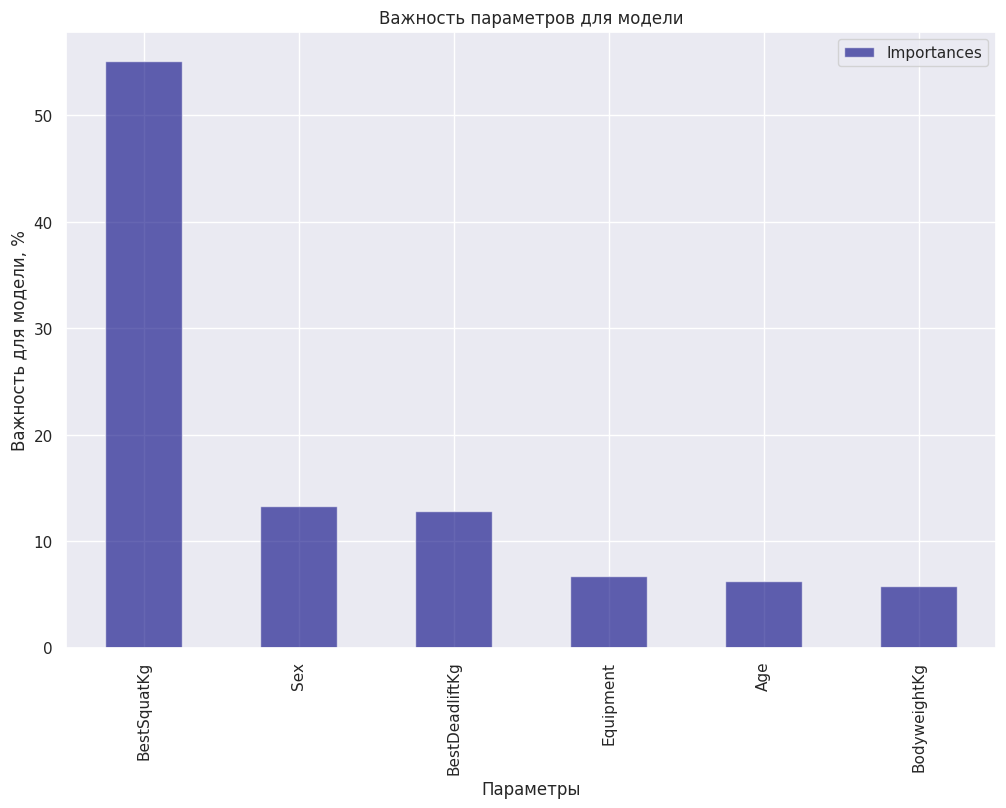

In [44]:
feature_importance = model_cb.get_feature_importance(prettified=True)

sns.set(rc={'figure.figsize': (12, 8)})
feature_importance.plot(
    x='Feature Id', y='Importances', kind='bar', color='navy', alpha=0.6
)
plt.xlabel('Параметры')
plt.ylabel('Важность для модели, %')
plt.title('Важность параметров для модели')

plt.show()

## Выводы по разделу.
- Данные разбиты на тренировочную, валидационную и тестовую выборки.
- Категориальный параметр закодирован с помощью OHE.
- Числовые параметры подвергнуты стандартизации.
- На тренировочной выборки обучены и дали предсказание на валидационной медианная dummy-модель, линейная регрессия и CatBoost. Значение метрики MAPE оказалось ниже всего у последней модели (11.84 %).
- CatBoost дал предсказание на тестовых данных, величина MAPE на них 11.58 %.
- Наиболее важным для модели был параметр, отвечающий за рекорд спортсмена в приседе со штангой, наименее важным - масса тела спортсмена.

# Общие выводы по проекту.
Как видно из результатов проекта, вопрос прогнозирования спортивных результатов на основе информации о спортсмене вполне неплохо может быть решён с помощью машинного обучения. Величина метрики MAPE 11.58 % без особых проблем была достигнута путём применения модели CatBoost.